In [1]:
import pandas as pd 
import numpy as np

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
ads_data = pd.read_csv('C:/Users/1233-/Downloads/ads/ads_data.csv', parse_dates=['date', 'time'])
client_data = pd.read_csv('C:/Users/1233-/Downloads/ads/ads_clients_data.csv', parse_dates=['date', 'create_date'])

In [4]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [5]:
client_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [58]:
# Посчитать среднее количество по каждому типу события
# Для этого сначала предобрабатываем данные 
# После заводим новую таблицу с нужными нам значениями и считаем среднее по всем колонкам, предворительно заполнив пропуски 0
ads_data.groupby(['ad_id','event'], as_index=False) \
                .agg({'has_video': 'count'}).pivot(index='ad_id', columns='event', values='has_video').fillna(0).mean().round()

event
click    113.0
view     923.0
dtype: float64

In [59]:
# Аналогичный ответ с другим решением
# тут мы обошлись без группировки
ads_data.pivot_table(index='ad_id', columns='event', values='has_video', aggfunc='count').fillna(0).mean().round()

event
click    113.0
view     923.0
dtype: float64

In [61]:
# Необходимо построить график распределения event == просмотры
# Предобрабатываем данные, чтобы после отобрать только строки где есть просмотры
dis = ads_data.groupby(['ad_id','event'], as_index=False) \
                .agg({'has_video': 'count'})

In [8]:
dis = dis.query('event == "view"')

In [64]:
# Применяем логарифмирование к нужной серии
# Прологарифмируйте число показов, а затем постройте такой график, 
# чтобы можно было понять форму распределения. 
w = np.log(dis.has_video)

C:\Users\1233-\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='has_video', ylabel='Density'>

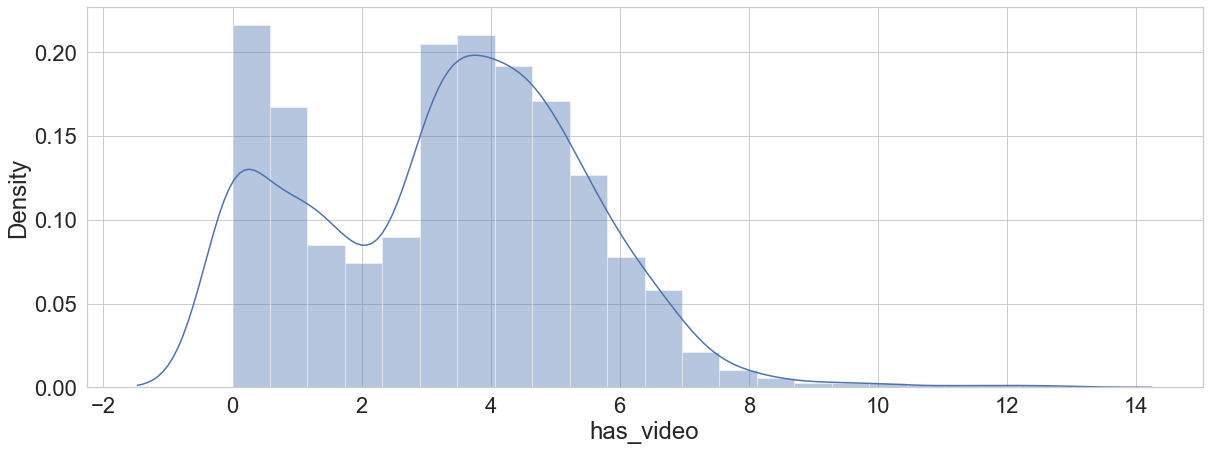

In [65]:
# Строим наш график
sns.distplot(w)

In [67]:
# Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, 
# не учитывая объявления, у которых не было показов (обычное среднее). 
# После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

# Предобрабатываем данные и считаем кол-во обявления по каждому из дней
group_date = ads_data.query('event == "view"').groupby(['ad_id', 'date']).agg({'platform': 'count'})

In [68]:
# На основе полученных данных делаем группировку по дате и считаем среднее на каждый из день
# После чего считаем скользящее среднее и удаляем пропуски
roll_df = group_date.groupby('date').agg({'platform': 'mean'}).platform.rolling(2).mean().round().reset_index().dropna()

In [69]:
# Считаем обычное среднее
mean_df = group_date.groupby('date').agg({'platform': 'mean'}).reset_index()

In [76]:
# Посчитайте, в какой день наблюдается наибольшая разница по модулю между 
# арифметическим средним и скользящим средним?
abs(mean_df.platform - roll_df.platform)

0           NaN
1      8.213018
2     12.952778
3    255.901720
4    121.109677
5    320.877273
Name: platform, dtype: float64

<AxesSubplot:xlabel='date', ylabel='platform'>

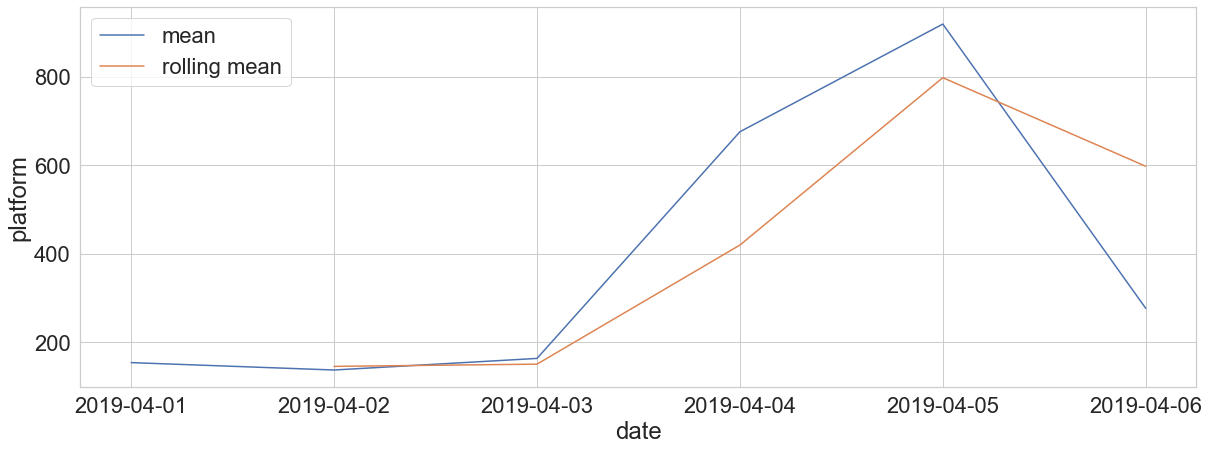

In [78]:
# Давайте попробуем нанести на один график значения просто среднего количества показов по дням 
# и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).

sns.lineplot(x=mean_df.date, y=mean_df.platform, label='mean')
sns.lineplot(x=roll_df.date, y=roll_df.platform, label='rolling mean')

In [81]:
# Нужно объединить два датафрейма по колонке community_id
# Чтобы после узнать среднее кол-во дне для клиентов от даты регистрации до даты размещения первой рекламы
merg_df = ads_data.merge(client_data, on='client_union_id')
merg_df.drop(columns=['date_y', 'community_id'], inplace=True)

In [82]:
merg_df.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


In [83]:
# Заводим новый столбец, где будем хранить разницу
# Между датой размещения первой рекламы и даты регистрации
merg_df = merg_df.assign(subtraction_date = merg_df.date_x - merg_df.create_date )


In [84]:
# Узнаем среднее кол-во дней которое прошло после даты регистрации и до даты размещения первой рекламы
# Кол-во таких дней для клиента будет равно минимальному кол-во дней
merg_df.groupby('client_union_id') \
                    .agg({'subtraction_date': 'min'}).subtraction_date.mean()

Timedelta('124 days 09:04:43.532219570')

In [85]:
# Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.
# Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), 
# к общему числу клиентов. 
# Например, 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу. 
# В таком случае конверсия будет равна 5% (50/1000 *100 = 5%)
# Получаем новую таблицу, где значения будет минимальные значения для каждой группы
done = merg_df.groupby('client_union_id', as_index=False) \
                    .agg({'subtraction_date': 'min'})

# Кол-во клиентов подходяих под наше условие(дней прошло <= 365)
count_done = done.shape[0]

In [86]:
# Кол-во всех клиентов, берем из таблицы с клиентами
# Так как при мерже мы отобрали только тех, у которых были выполнены рекламные действия
main_client = client_data.shape[0]

In [87]:
# Высчитываем конверсию клиентов
# Делим нужное нам отобранное колво на общее колво клиентов и переводим в проценты
round(count_done / main_client * 100, 2)

0.69

In [88]:
# Давайте разобъем наших клиентов по промежуткам от создания рекламного кабинета 
# до запуска первого рекламного объявления.

# Определите, сколько уникальных клиентов запустили свое первое объявление 
# в первый месяц своего существования (от 0 до 30 дней). 
# Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365].


# Создаем списко типа timedelta из нужных промежутков
bins = pd.to_timedelta(['0d', '30d', '90d', '180d', '365d'])

In [89]:
# Создаем новую колонку где значениями будут группы отобранные по интервалам переданным в списке
# Так же передаем списко с названиями групп
merg_df = merg_df.assign(rank_days = pd.cut(merg_df.subtraction_date, bins=bins, 
                                            labels=['1 month', '2-3 month', '3-6 month', '6-12 month']))

In [90]:
# Отбираем данные принадлежащие определенной группе и считаем уникальное 
# кол-во клиентов в этой группе
merg_df.query('rank_days == "1 month"').client_union_id.nunique()

11

In [91]:
# Необходимо построить интерактивный барплот

# Делаем предобработку данных гурпируя по рангам и заполняя числом уникальных клиентов в группах
df_bar = merg_df.groupby('rank_days', as_index=False) \
                            .agg({'client_union_id': 'nunique'})

In [92]:
# Строим браплот
fig = px.bar(df_bar, x='rank_days', y='client_union_id')
fig.show()

## Дополнительный проект
### В данном проекте вы поработаете с довольно нетипичными для аналитика данными: gff файлом

In [100]:
# Для выполнения этого задания нам нужны будут регулярные выражения
import re

In [110]:
# Счтываем данные в расширении gff.tsv
# Чтобы это сделать применяем read_csv и ставим разделитель табуляцию
gene_data = pd.read_csv('C:/Users/1233-/Downloads/gff.tsv', sep='\t')

In [111]:
gene_data.head()

,seq_id,source,type,start,end,score,strand,phase,attributes
0,chr17,RefSeq,exon,6811330,6811453,.,+,.,Parent=XM_001475631.1
1,chr17,RefSeq,CDS,6808204,6808245,.,+,0,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...
2,chr17,RefSeq,CDS,6811792,6811869,.,+,2,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...
3,chr17,RefSeq,exon,6806513,6806553,.,+,.,Parent=XM_001475631.1
4,chr17,RefSeq,five_prime_UTR,6806513,6806526,.,+,.,Parent=XM_001475631.1


In [112]:
# Создаем новую колонку и с помощью функции extract парсим данные из нужной строки
# для этого используем маску регулярного выражения

gene_data = gene_data.assign(Parent_atr = gene_data.attributes.str.extract('Parent=([\w.]+)'))

In [113]:
gene_data.head()

,seq_id,source,type,start,end,score,strand,phase,attributes,Parent_atr
0,chr17,RefSeq,exon,6811330,6811453,.,+,.,Parent=XM_001475631.1,XM_001475631.1
1,chr17,RefSeq,CDS,6808204,6808245,.,+,0,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...,XM_001475631.1
2,chr17,RefSeq,CDS,6811792,6811869,.,+,2,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...,XM_001475631.1
3,chr17,RefSeq,exon,6806513,6806553,.,+,.,Parent=XM_001475631.1,XM_001475631.1
4,chr17,RefSeq,five_prime_UTR,6806513,6806526,.,+,.,Parent=XM_001475631.1,XM_001475631.1


In [120]:
# Другой метод получения нужных значений
def find_parent(atr):
    for at in atr:
        if at.startswith('Parent='):
            return at
gene_data.attributes.str.split(';') \
                .apply(find_parent) \
                .str.split('=').str[1] \
                .str.strip(',')

0      XM_001475631.1
1      XM_001475631.1
2      XM_001475631.1
3      XM_001475631.1
4      XM_001475631.1
            ...      
507    XM_001475631.1
508    XM_001475631.1
509    XM_001475631.1
510    XM_001475631.1
511    XM_001475631.1
Name: attributes, Length: 512, dtype: object

In [114]:
# Считаем кол-во получившихся значений в новой колонке
gene_data.Parent_atr.value_counts()

XM_001475631.1    479
NC_000083.5        33
Name: Parent_atr, dtype: int64

In [115]:
# Находим тип, который встречается наиболее часто
gene_data.type.value_counts()

exon               201
CDS                170
five_prime_UTR      47
mRNA                33
three_prime_UTR     32
protein             29
Name: type, dtype: int64